# Transfer Learning with MobileNetV2

## Table of Content

- [1 - Packages](#1)
    - [1.1 Create the Dataset and Split it into Training and Validation Sets](#1-1)
- [2 - Preprocess and Augment Training Data](#2)
- [3 - Using MobileNetV2 for Transfer Learning](#3)
    - [3.1 - Inside a MobileNetV2 Convolutional Building Block](#3-1)
    - [3.2 - Layer Freezing with the Functional API](#3-2)
        - [3.3 - Fine-tuning the Model](#3-3)
    

<a name='1'></a>
## 1 - Packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


<a name='1-1'></a>
### 1.1 Create the Dataset and Split it into Training and Validation Sets


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


Now let's take a look at some of the images from the training set:

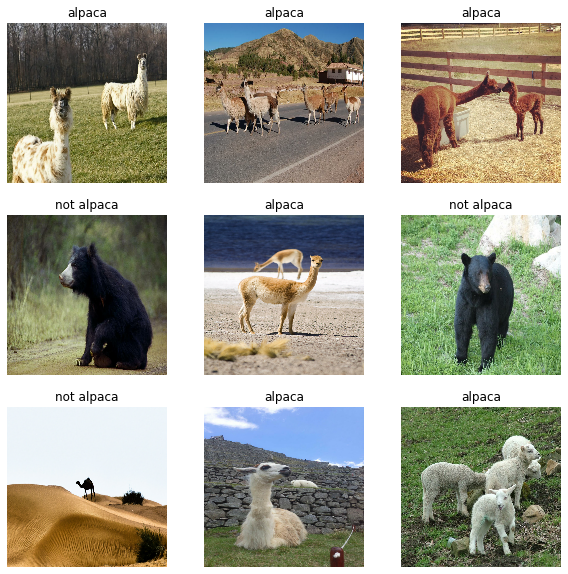

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Preprocess and Augment Training Data


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation

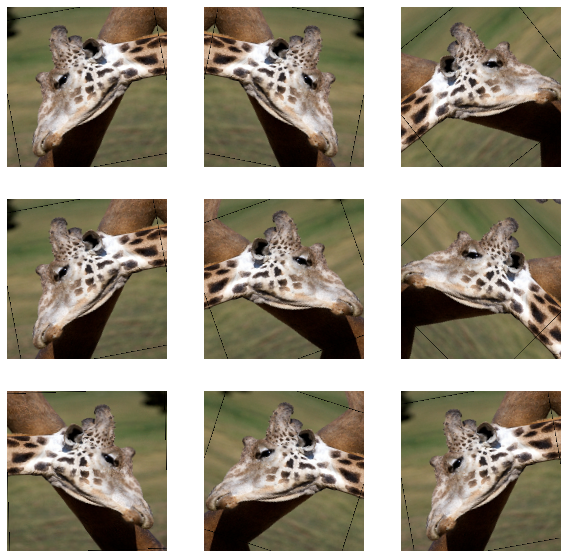

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='3'></a>
## 3 - Using MobileNetV2 for Transfer Learning

<a name='3-1'></a>
### 3.1 - Inside a MobileNetV2 Convolutional Building Block

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps:

1. Depthwise convolution: The first step calculates an intermediate result by convolving on each of the channels independently.

2. Pointwise convolution: In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer.

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information.

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers.

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [ ]:
#Shows the different label probabilities in one tensor
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [ ]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

40960/35363 [==================================] - 0s 0us/step


[[('n04589890', 'window_screen', 0.42582113),
  ('n02708093', 'analog_clock', 0.09275588)],
 [('n04589890', 'window_screen', 0.23985851),
  ('n03887697', 'paper_towel', 0.14802593)],
 [('n04589890', 'window_screen', 0.7449468),
  ('n03598930', 'jigsaw_puzzle', 0.021948555)],
 [('n04589890', 'window_screen', 0.3354602),
  ('n03530642', 'honeycomb', 0.0762895)],
 [('n04589890', 'window_screen', 0.27327338),
  ('n03733281', 'maze', 0.08846959)],
 [('n04589890', 'window_screen', 0.6745217),
  ('n03530642', 'honeycomb', 0.076599255)],
 [('n04589890', 'window_screen', 0.79128474),
  ('n04209239', 'shower_curtain', 0.0924166)],
 [('n04589890', 'window_screen', 0.1646301),
  ('n03598930', 'jigsaw_puzzle', 0.08749153)],
 [('n03598930', 'jigsaw_puzzle', 0.37021384),
  ('n04589890', 'window_screen', 0.099569514)],
 [('n04589890', 'window_screen', 0.6161648),
  ('n03887697', 'paper_towel', 0.054877095)],
 [('n03530642', 'honeycomb', 0.254489),
  ('n04589890', 'window_screen', 0.24874294)],
 [('n04

<a name='3-2'></a>
### 3.2 - Layer Freezing with the Functional API

To modify the classifier task to use the pretrained model so it can recognize alpacas, I first

1. Deleted the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Added a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Froze the base model and trained the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [ ]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''


    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    base_model.trainable = False
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)

    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # Add the new Binary classification layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    #include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(rate=0.2)(x)

    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tf.keras.layers.Dense(units=1)

    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [ ]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [ ]:
base_learning_rate = 0.0001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 8s 846ms/step - loss: 0.7492 - accuracy: 0.5573 - val_loss: 0.6632 - val_accuracy: 0.5077
Epoch 2/5
9/9 [==============================] - 7s 788ms/step - loss: 0.7603 - accuracy: 0.5153 - val_loss: 0.6215 - val_accuracy: 0.5231
Epoch 3/5
9/9 [==============================] - 7s 757ms/step - loss: 0.7247 - accuracy: 0.5687 - val_loss: 0.5934 - val_accuracy: 0.5846
Epoch 4/5
9/9 [==============================] - 7s 799ms/step - loss: 0.6901 - accuracy: 0.5534 - val_loss: 0.5764 - val_accuracy: 0.5846
Epoch 5/5
9/9 [==============================] - 7s 801ms/step - loss: 0.7017 - accuracy: 0.5802 - val_loss: 0.5627 - val_accuracy: 0.6000


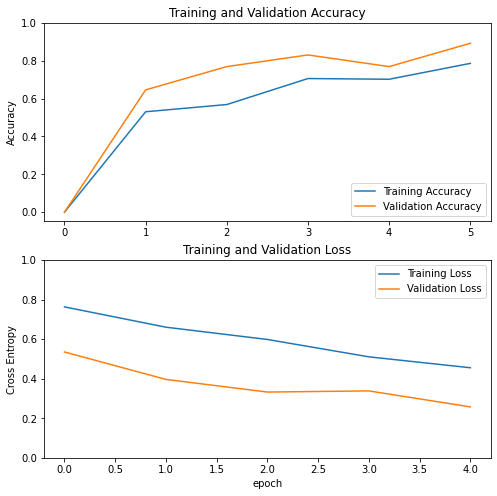

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
class_names

['alpaca', 'not alpaca']

<a name='3-3'></a>
### 3.3 - Fine-tuning the Model



In [ ]:
base_model = model2.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a BinaryCrossentropy loss function
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 9s 1s/step - loss: 0.6122 - accuracy: 0.6908 - val_loss: 0.2575 - val_accuracy: 0.9231
Epoch 6/10
9/9 [==============================] - 8s 935ms/step - loss: 0.3762 - accuracy: 0.7710 - val_loss: 0.1733 - val_accuracy: 0.9385
Epoch 7/10
9/9 [==============================] - 8s 935ms/step - loss: 0.2495 - accuracy: 0.9046 - val_loss: 0.1490 - val_accuracy: 0.9231
Epoch 8/10
9/9 [==============================] - 9s 944ms/step - loss: 0.1864 - accuracy: 0.9275 - val_loss: 0.0879 - val_accuracy: 0.9846
Epoch 9/10
9/9 [==============================] - 8s 913ms/step - loss: 0.1482 - accuracy: 0.9427 - val_loss: 0.0920 - val_accuracy: 0.9846
Epoch 10/10
9/9 [==============================] - 8s 912ms/step - loss: 0.1160 - accuracy: 0.9656 - val_loss: 0.0675 - val_accuracy: 0.9538


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

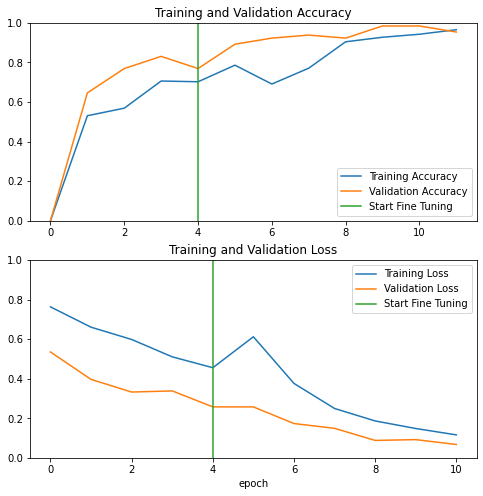

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()